<a href="https://colab.research.google.com/github/jhhan0/self-study-ml/blob/main/notes/mnist-cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Dataset Classification using the Convolutional Neural Network 

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

Check if this Colab is running with GPU.

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
mnist, info = tfds.load('mnist', with_info=True)

In [4]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

Normalize the image pixel values to a range between 0.0 to 1.0 for ease of training.

In [5]:
train_mnist = mnist['train']
test_mnist = mnist['test']

train_mnist = train_mnist.map(lambda x: (tf.cast(x['image'], tf.float32) / 255.0, tf.cast(x['label'], tf.uint8)))
test_mnist = test_mnist.map(lambda x: (tf.cast(x['image'], tf.float32) / 255.0, tf.cast(x['label'], tf.uint8)))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
tf.random.set_seed(1)
BUFFER_SIZE = 60000
BATCH_SIZE = 64
EPOCHS = 20

train_mnist = train_mnist.cache().shuffle(buffer_size=BUFFER_SIZE).repeat().batch(BATCH_SIZE)
test_mnist = test_mnist.batch(BATCH_SIZE)

Create CNN Model using `keras.models.Sequential` with `layers.Conv2D` and `layers.MaxPool2D` layers.

In [7]:
cnn_model = tf.keras.models.Sequential([
    # conv layer
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', data_format='channels_last', name='conv_1', activation='relu'),
    # sub-sampling layer
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='maxpool_1'),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', data_format='channels_last', name='conv_2', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='maxpool_2'),
    
    # global average pooling layer to aggregate and take a mean of all feature map values
    tf.keras.layers.GlobalAveragePooling2D(),

    # flatten into a 1-D vector
    tf.keras.layers.Flatten(),
    # dense layer
    tf.keras.layers.Dense(64, name='dense_1', activation='relu'),
    # dropout layer
    tf.keras.layers.Dropout(rate=0.5),
    # output dense layer
    tf.keras.layers.Dense(10, name='dense_2', activation='softmax')
])

In [8]:
cnn_model.build(input_shape=(None, 28, 28, 1))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                        

Compile and train the model.

In [9]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
STEPS_PER_EPOCHS = (info.splits['train'].num_examples / BATCH_SIZE)
history = cnn_model.fit(train_mnist, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCHS)

Epoch 1/20
937/937 [==============================] - 20s 5ms/step - loss: 1.5499 - accuracy: 0.4280
Epoch 2/20
937/937 [==============================] - 4s 4ms/step - loss: 0.8991 - accuracy: 0.6952
Epoch 3/20
937/937 [==============================] - 4s 5ms/step - loss: 0.7065 - accuracy: 0.7680
Epoch 4/20
937/937 [==============================] - 4s 4ms/step - loss: 0.5941 - accuracy: 0.8105
Epoch 5/20
937/937 [==============================] - 4s 4ms/step - loss: 0.5270 - accuracy: 0.8347
Epoch 6/20
937/937 [==============================] - 5s 5ms/step - loss: 0.4777 - accuracy: 0.8511
Epoch 7/20
937/937 [==============================] - 4s 4ms/step - loss: 0.4427 - accuracy: 0.8636
Epoch 8/20
937/937 [==============================] - 4s 4ms/step - loss: 0.4148 - accuracy: 0.8715
Epoch 9/20
937/937 [==============================] - 5s 5ms/step - loss: 0.3953 - accuracy: 0.8773
Epoch 10/20
937/937 [==============================] - 5s 5ms/step - loss: 0.3774 - accuracy: 0.884

This section for save and load the model that was previously trained above.

In [ ]:
# cnn_model.save('cnn_model_mnist.h5', overwrite=True, include_optimizer=True, save_format='h5')

In [ ]:
# new_model = tf.keras.models.load_model('cnn_model_mnist.h5')

In [ ]:
# new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 14, 14, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 7, 7, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                        

Evaluate the model using the test dataset which they are the unseen data while training the model.

In [11]:
result = cnn_model.evaluate(test_mnist)
print('Eval loss: {}, Eval acc: {}'.format(*result))

157/157 [==============================] - 1s 8ms/step - loss: 0.1087 - accuracy: 0.9677
Eval loss: 0.10865984857082367, Eval acc: 0.9677000045776367


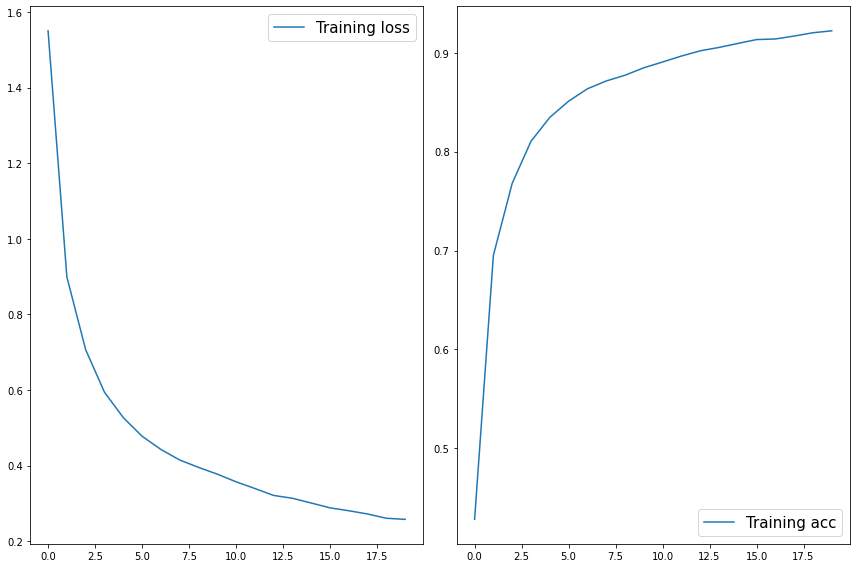

In [15]:
hist = history.history
plt.figure(figsize=(12, 8))

# plot loss
plt.subplot(1, 2, 1)
plt.plot(hist['loss'], label='Training loss')
# plt.plot(hist['val_loss'], label='val loss')
plt.legend(loc='upper right', fontsize=15)
plt.tight_layout()

# plot accuracy
plt.subplot(1, 2, 2)
plt.plot(hist['accuracy'], label='Training acc')
# plt.plot(hist['val_accuracy'], label='val acc')
plt.legend(loc='lower right', fontsize=15)
plt.tight_layout()

plt.show()

Display 10 mnist images with its correct label and predicted value from the model.

In [16]:
# first, unbatch the test dataset
test_mnist = test_mnist.unbatch()

In [19]:
test_mnist = test_mnist.batch(10)

In [ ]:
# else you can use tf.data.Datset.rebatch() to rebatch the test dataset as well
# test_mnist = test_mnist.rebatch(10)

In [21]:
samples = next(iter(test_mnist))

In [22]:
preds = tf.argmax(cnn_model.predict(samples[0]), axis=1)
print(preds)

1/1 [==============================] - 0s 141ms/step
tf.Tensor([2 0 4 8 7 6 0 6 3 1], shape=(10,), dtype=int64)


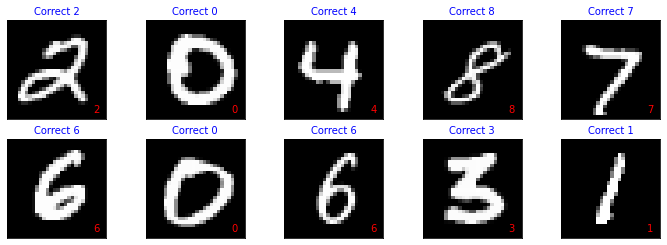

In [23]:
fig = plt.figure(figsize=(12, 4))
for i in range(10):
  ax = fig.add_subplot(2, 5, i+1)
  ax.set_title('Correct {}'.format(samples[1].numpy()[i]), size=10, color='blue')
  img = samples[0][i, :, :, 0]
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img, cmap='gray')
  ax.text(0.9, 0.1, '{}'.format(preds[i]), size=10, color='red', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.show()